In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from helpers import *

Read Training Images
===

In [2]:
# Divide up into cars and notcars
v_images = glob.glob('vehicles/**/*.png', recursive=True)
nv_images = glob.glob('non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []
for image in v_images:
    cars.append(image)
for image in nv_images:
    notcars.append(image)

In [3]:
# Use a subset of the training data
#cars = shuffle(cars)[:2000]
#notcars = shuffle(notcars)[:2000]

Extract HOG Features from the Training Data
===

In [4]:
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 32
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_hog_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_hog_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

44.92 Seconds to extract HOG features...


Extract Color Features from the Training Data
===

In [16]:
colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range=(0, 256)

t=time.time()
car_color_features = extract_color_features(cars, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range)
notcar_color_features = extract_color_features(notcars, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract Color features...')

135.58 Seconds to extract Color features...


Combine both HOG and Color Features
===

In [17]:
car_features = np.hstack((car_hog_features, car_color_features))
notcar_features = np.hstack((notcar_hog_features, notcar_color_features))

#car_features = car_hog_features
#notcar_features = notcar_hog_features

Train Linear SVC Classifier
===

In [18]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 32 pixels per cell and 2 cells per block
Feature vector length: 3276
18.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9693
My SVC predicts:  [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
For these 10 labels:  [1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
0.10175 Seconds to predict 10 labels with SVC


Window Search
===

In [99]:
# Define a single function that can extract features using hog sub-sampling (combined with color features) and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):   
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window, window))
            
            # Get color spatial features for the image patch
            spatial_features = bin_spatial(subimg, size=(32, 32))
            
            # Get color histogram features for the image patch
            hist_features = color_hist(subimg, nbins=32, bins_range=(0, 256))

            # Combine all features
            features = np.hstack((hog_features, spatial_features, hist_features))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            #if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6)                
    return draw_img

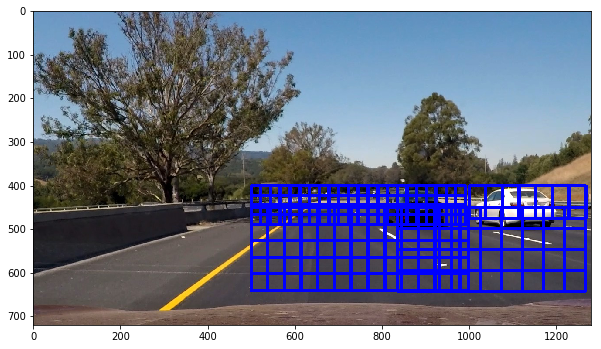

In [117]:
# Test find cars function
# Read test image
img = mpimg.imread('test_images/test6.jpg')

# Top Right
ystart = 400
ystop = 500
xstart = 1000
xstop = 1270
scale = 1.2
out_img = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

# Top Left
ystart = 400
ystop = 500
xstart = 500
xstop = 1000
scale = 0.7
out_img = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

# Bottom Right
ystart = 450
ystop = 650
xstart = 835
xstop = 1270
scale = 1.5
out_img = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

# Bottom Left
ystart = 450
ystop = 650
xstart = 500
xstop = 1000
scale = 1.2
out_img = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

plt.figure(figsize=(10,20))
plt.imshow(out_img)

In [96]:
# define a pipeline to be fed video frames
def pipeline(img):    
    # Top Right
    ystart = 400
    ystop = 500
    xstart = 1000
    xstop = 1270
    scale = 1.5
    out_img = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    # Top Left
    ystart = 400
    ystop = 500
    xstart = 500
    xstop = 1000
    scale = 0.7
    out_img = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    # Bottom Right
    ystart = 500
    ystop = 650
    xstart = 1000
    xstop = 1270
    scale = 2.0
    out_img = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    # Bottom Left
    ystart = 500
    ystop = 650
    xstart = 500
    xstop = 1000
    scale = 1.5
    out_img = find_cars(out_img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    return out_img

Test on Videos
===

In [97]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [98]:
output = 'output.mp4'
raw_clip = VideoFileClip("project_video.mp4")
output_clip = raw_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [20:00<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 20min 1s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [14]:
# Define a function to extract some images from a video.
def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = "project_video.mp4"
imgdir = "difficult_images"
times = np.linspace(20, 25, 51)


extract_frames(movie, times, imgdir)

NameError: name 'os' is not defined